This notebook is to test different ansatz for VarQITE algorithm. We are using the VarQITE algorithm to find the eigenvalues of a Tight Binding Hamiltonian. We are currently testing an ansatz which creates superposition of states of a particular sub_space (such that number of ones in all the superposed states is same). We then expect this ansatz to give the lowest eigenvalue of that sub-space.  
- Run this notebook for different ansatz (currently : su2, easy, easy3)

In [1]:
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Statevector
from tabulate import tabulate
from itertools import combinations
from qiskit.circuit.library import EfficientSU2
import math
import time
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.algorithms import TimeEvolutionProblem
from qiskit.algorithms import VarQITE
from qiskit.primitives import Estimator
from qiskit.quantum_info import Statevector
from qiskit.algorithms import SciPyImaginaryEvolver
import pylab
from qiskit.algorithms.gradients import ReverseEstimatorGradient, ReverseQGT

In [2]:
def tb0_JW(N,e,t) : 
    strings = []
    opt = SparsePauliOp.from_sparse_list([("I", [0], 0)], num_qubits=N)  
    for k in range(N) : 
        a0='I'*(N)
        a1 = 'I'*(k)+'Z' +'I'*(N-k-1)

        b0='I'*N
        b0_list = list(b0)
        b0_list[k] = 'X'
        b0_list[(k+1)%N] = 'X'
        new_b0 = ''.join(b0_list)

        b1='I'*N
        b1_list = list(b0)
        b1_list[k] = 'Y'
        b1_list[(k+1)%N] = 'Y'
        new_b1 = ''.join(b1_list)

        strings.append([a0,a1,new_b0,new_b1])
        val = 1
        if N==2 and k==1 : 
            val = 0
        opt += SparsePauliOp.from_list([(a0, 0.5*e[k]), (a1, -0.5*e[k]),(new_b0, 0.5*t*val),(new_b1, 0.5*t*val)])
    return opt  

def spinless_basis(N,r) : 
    basis_set = []
    lattice = list(range(N))
    places = list(combinations(lattice, r))
    for combination in places : 
        basis = [False] *N
        for index in combination : 
            basis[index] = True 
        basis_set.append(basis)
    return basis_set

In [3]:
N=3
e=[1]*N
t=7
H_op = tb0_JW(N,e,t)

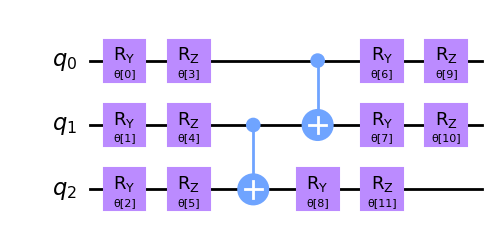

In [4]:
#This finds the right results for less number of qubits and takes a lot of time 
su2 = EfficientSU2(H_op.num_qubits, reps=1)
su2.decompose().draw('mpl')
#print(su2.parameters)

ParameterView([Parameter(theta)])


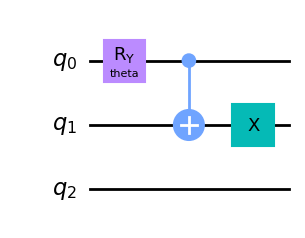

In [5]:
#We create this easy, custom ansatz for 2 qubits
easy = QuantumCircuit(N)
param = Parameter("theta")
easy.ry(param,0)
easy.cx(0,1)
easy.x(1)
#print(easy)
print(easy.parameters)
easy.draw('mpl')

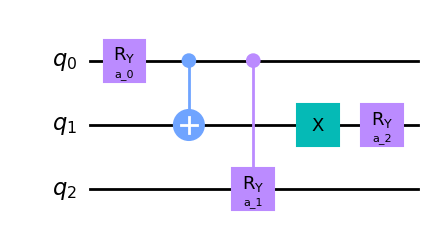

In [6]:
#We use a similar approach as before to create ansatz for 3 qubits 
easy3 = QuantumCircuit(3)
param = [Parameter("a_0"),Parameter("a_1"),Parameter("a_2") ]
easy3.ry(param[0],0)
easy3.cx(0,1)
easy3.cry(param[1],0,2)
easy3.x(1)
easy3.ry(param[2],1)
easy3.draw('mpl')

In [7]:
'''Try different ansatz here :
ansatz=su2
ansatz=easy
ansatz=easy3'''

ansatz = easy3
init_param_values={}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]]=1
print(init_param_values)

{Parameter(a_0): 1, Parameter(a_1): 1, Parameter(a_2): 1}


In [8]:
var_principle = ImaginaryMcLachlanPrinciple()

exp_time = 5.0
aux_ops = [H_op]
evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)

backend = Aer.get_backend('statevector_simulator')

In [9]:
#We use the VarQITE algorithm to estimate lowest eigenvalue

start_time = time.time()
var_principle = ImaginaryMcLachlanPrinciple(qgt = ReverseQGT() , gradient = ReverseEstimatorGradient())
evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
evolution_result_eff = var_qite.evolve(evolution_problem)
end_time = time.time()
elapsed_time = end_time - start_time

print("Elapsed time: ", elapsed_time, " seconds")

Elapsed time:  24.064607620239258  seconds


In [10]:
#This is the evolved state
eff_circ = evolution_result_eff.evolved_state

In [11]:
#We use the statevector simulator to find the eigenstate corresponding to lowest eigenvalue
eff_job = execute(eff_circ, backend)
eff_result = eff_job.result()
eff_statevector = eff_result.get_statevector()

#print(eff_statevector)
final_sv = [np.round(x,3) for x in np.asarray(eff_statevector)]
print("Rounded eigenstate:")
print(final_sv)

Rounded eigenstate:
[(-0+0j), (-0.707+0j), (0.707+0j), (-0-0j), -0j, -0j, 0j, 0j]


In [12]:
#This is the lowest eigenvalue
h_exp_val = np.array([ele[0][0] for ele in evolution_result_eff.observables])
h_exp_val[-1]

-5.999999999987513

Now we use the SciPyImaginaryEvolver to calculate the imag9inary time evolution classically, just to verify 

In [13]:
init_state = Statevector(ansatz.assign_parameters(init_param_values))

In [14]:
evolution_problem = TimeEvolutionProblem(H_op, exp_time, initial_state=init_state, aux_operators=aux_ops)
exact_evol = SciPyImaginaryEvolver(num_timesteps=501)
sol = exact_evol.evolve(evolution_problem)

In [15]:
#Exact lowest eigenvalue
exact_h_exp_val = sol.observables[0][0].real
exact_h_exp_val[-1]

-5.999995849926837

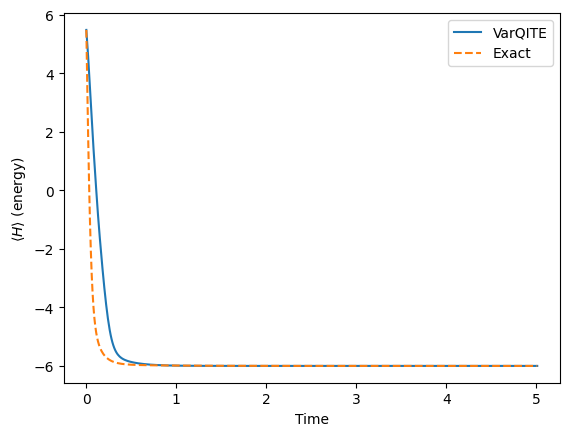

In [16]:
#Comparison of VarQITE and Classical evolution
times = evolution_result_eff.times
pylab.plot(times, h_exp_val, label= "VarQITE")
pylab.plot(times, exact_h_exp_val , label= "Exact",  linestyle='--')
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

### References  
1. [Variational Quantum Time Evolution - Qiskit Documentation](https://qiskit.org/documentation/tutorials/algorithms/11_VarQTE.html)  
2. [Yuan et al. Quantum 3, 191](https://quantum-journal.org/papers/q-2019-10-07-191/)